In [1]:
import numpy as np
import matplotlib.pyplot as plt

def trapezoidal(x, a, b, c, d):
    return np.maximum(np.minimum(np.minimum((x - a) / (b - a + 1e-6), 1), (d - x) / (d - c + 1e-6)), 0)

# Entrada

def temperature(temp):
    return {
        "baixa" : trapezoidal(temp,  0,  0, 10, 20),
        "media" : trapezoidal(temp, 15, 20, 30, 35),
        "alta"  : trapezoidal(temp, 30, 35, 40, 40),
    }

def humidity(hum):
    return {
        "baixa" : trapezoidal(hum,  0,  0, 20, 40),
        "media" : trapezoidal(hum, 30, 40, 60, 70),
        "alta"  : trapezoidal(hum, 60, 80,100,100),
    }

def people_membership(num):
    return {
        "poucas" : trapezoidal(num, 0, 0, 1, 3),
        "media"  : trapezoidal(num, 2, 4, 6, 8),
        "muitas" : trapezoidal(num, 6, 8,10,10),
    }



In [2]:
# Função para mostrar funções de pertinência assim que definidas

def print_memberships(var_name, universe, memberships):
    plt.figure(figsize=(8, 4))
    for label in memberships:
        values = memberships[label]
        plt.plot(universe, values, label=label)
    plt.title(f'Funções de Pertinência - {var_name}')
    plt.xlabel(var_name)
    plt.ylabel('Grau de Pertinência')
    plt.legend()
    plt.grid(True)
    plt.show()

x_t = np.linspace(0, 50, 500)

temperature_labels = {
    "baixa": trapezoidal(x_t, 0, 0, 10, 20),
    "media": trapezoidal(x_t, 15, 20, 30, 35),
    "alta": trapezoidal(x_t, 30, 35, 40, 40),
}

# print_memberships("Temperatura (°C)", x_t, temperature_labels)

x_h = np.linspace(0, 100, 500)
humidity_labels = {
    "baixa": trapezoidal(x_h, 0, 0, 20, 40),
    "media": trapezoidal(x_h, 30, 40, 60, 70),
    "alta": trapezoidal(x_h, 60, 80, 100, 100),
}

# print_memberships("Umidade (%)", x_h, humidity_labels)

x_p = np.linspace(0, 10, 500)
people_labels = {
    "poucas": trapezoidal(x_p, 0, 0, 1, 3),
    "media": trapezoidal(x_p, 2, 4, 6, 8),
    "muitas": trapezoidal(x_p, 6, 8, 10, 10),
}

# print_memberships("Número de Pessoas", x_p, people_labels)

In [3]:
# Saída 

def output_ventilation(x):
    return {
        "fraca": trapezoidal(x, 0, 0, 2.5, 5),
        "moderada": trapezoidal(x, 3, 4.5, 5.5, 7),
        "forte": trapezoidal(x, 6, 7.5, 10, 10),
    }

# Regras (27)

rules = [
    ("baixa", "baixa", "poucas",  "fraca"),
    ("baixa", "baixa", "media",   "fraca"),
    ("baixa", "baixa", "muitas",  "moderada"),
    ("baixa", "media", "poucas",  "fraca"),
    ("baixa", "media", "media",   "fraca"),
    ("baixa", "media", "muitas",  "moderada"),
    ("baixa", "alta", "poucas",   "fraca"),
    ("baixa", "alta", "media",    "moderada"),
    ("baixa", "alta", "muitas",   "moderada"),
    ("media", "baixa", "poucas",  "fraca"),
    ("media", "baixa", "media",   "moderada"),
    ("media", "baixa", "muitas",  "moderada"),
    ("media", "media", "poucas",  "fraca"),
    ("media", "media", "media",   "moderada"),
    ("media", "media", "muitas",  "forte"),
    ("media", "alta", "poucas",   "moderada"),
    ("media", "alta", "media",    "forte"),
    ("media", "alta", "muitas",   "forte"),
    ("alta", "baixa", "poucas",   "moderada"),
    ("alta", "baixa", "media",    "forte"),
    ("alta", "baixa", "muitas",   "forte"),
    ("alta", "media", "poucas",   "moderada"),
    ("alta", "media", "media",    "forte"),
    ("alta", "media", "muitas",   "forte"),
    ("alta", "alta", "poucas",    "moderada"),
    ("alta", "alta", "media",     "forte"),
    ("alta", "alta", "muitas",    "forte"),
]

# cenários

cenarios = [
    (38, 90, 9),     
    # (3, 70, 6),   
    # (36, 50, 5), 
    # (31, 20, 1), 
    # (10, 50, 5),  
    # (12, 20, 2,   
]

# for temp_val, hum_val, people_val in cenarios:
#     execute(temp_val, hum_val, people_val)




--- Regras ativadas com AND=min / OR=max ---

 Cenário: T=38°C, H=90%, P=9

 Operadores: AND = min, OR = max

 Regra ativada: (alta, alta, muitas) → forte com α = 1.00



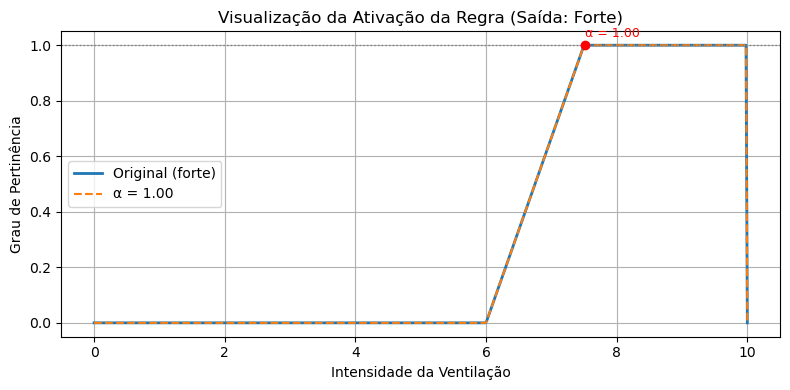


--- Regras ativadas com AND=prod / OR=sum ---

 Cenário: T=38°C, H=90%, P=9

 Operadores: AND = prod, OR = sum

 Regra ativada: (alta, alta, muitas) → forte com α = 1.00



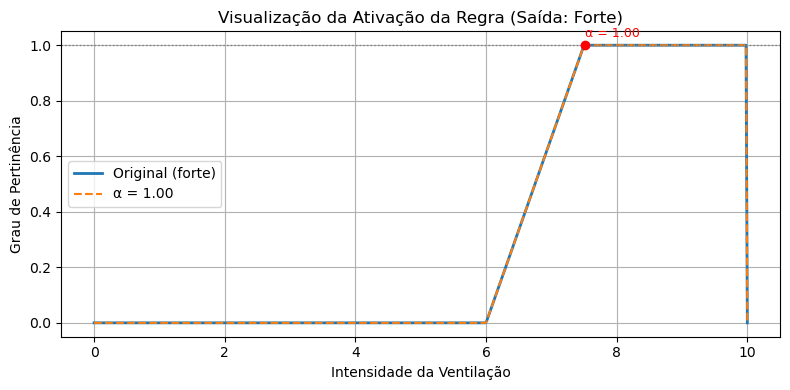

In [4]:
def visualizar_ativacao_regra(nome_saida, alphas=[0.4, 0.1]):
    x_output = np.linspace(0, 10, 500)
    saida_curve = output_ventilation(x_output)[nome_saida]

    plt.figure(figsize=(8, 4))
    plt.plot(x_output, saida_curve, label=f"Original ({nome_saida})", linewidth=2)

    for alpha in alphas:
        corte = np.minimum(saida_curve, alpha)
        plt.plot(x_output, corte, label=f"α = {alpha:.2f}", linestyle='--')

        plt.axhline(y=alpha, color='gray', linestyle=':', linewidth=1)

        x_peak = x_output[np.argmax(corte)]
        y_peak = np.max(corte)
        plt.plot(x_peak, y_peak, 'ro') 
        plt.text(x_peak, y_peak + 0.03, f"α = {alpha:.2f}", color='red', fontsize=9)

    plt.legend()
    plt.grid(True)
    plt.xlabel("Intensidade da Ventilação")
    plt.ylabel("Grau de Pertinência")
    plt.title(f"Visualização da Ativação da Regra (Saída: {nome_saida.capitalize()})")
    plt.tight_layout()
    plt.show()


def inferencia_mamdani(temp_val, hum_val, people_val, and_operator="min", or_operator="max", mostrar_ativacao=False):
    temp_fuzzy = temperature(temp_val)
    hum_fuzzy = humidity(hum_val)
    people_fuzzy = people_membership(people_val)
    x_output = np.linspace(0, 10, 500)
    output_agg = np.zeros_like(x_output)

    print(f"\n Cenário: T={temp_val}°C, H={hum_val}%, P={people_val}")
    print(f"\n Operadores: AND = {and_operator}, OR = {or_operator}")

    ativacoes = {}

    for rule in rules:
        temp_label, hum_label, people_label, output_label = rule

        temp_value = temp_fuzzy[temp_label]
        hum_value = hum_fuzzy[hum_label]
        people_value = people_fuzzy[people_label]

        if and_operator == "min":
            activation = np.minimum(np.minimum(temp_value, hum_value), people_value)
        elif and_operator == "prod":
            activation = temp_value * hum_value * people_value
        else:
            raise ValueError("Operador AND inválido.")

        alpha = np.max(activation)
        if alpha > 0.01:
            print(f"\n Regra ativada: ({temp_label}, {hum_label}, {people_label}) → {output_label} com α = {alpha:.2f}\n")
            output_curve = output_ventilation(x_output)[output_label]
            rule_curve = np.minimum(output_curve, activation)

            if or_operator == "max":
                output_agg = np.maximum(output_agg, rule_curve)
            elif or_operator == "sum":
                output_agg = np.minimum(output_agg + rule_curve, 1)
            else:
                raise ValueError("Operador OR inválido.")

            ativacoes[output_label] = max(ativacoes.get(output_label, 0), alpha)

    if mostrar_ativacao and ativacoes:
        saida_mais_ativada = max(ativacoes, key=ativacoes.get)
        alpha_final = ativacoes[saida_mais_ativada]
        visualizar_ativacao_regra(saida_mais_ativada, alphas=[alpha_final])
    elif not ativacoes:
        print(" Nenhuma regra foi ativada.")
    
    return x_output, output_agg

for temp, hum, people in cenarios:
    print(f"\n--- Regras ativadas com AND=min / OR=max ---")
    inferencia_mamdani(temp, hum, people, and_operator="min", or_operator="max", mostrar_ativacao=True)

    print(f"\n--- Regras ativadas com AND=prod / OR=sum ---")
    inferencia_mamdani(temp, hum, people, and_operator="prod", or_operator="sum", mostrar_ativacao=True)



Cenário: T=38°C, H=90%, P=9

Centroide

 Cenário: T=38°C, H=90%, P=9

 Operadores: AND = min, OR = max

 Regra ativada: (alta, alta, muitas) → forte com α = 1.00

Saída defuzzificada (centroid): 8.34


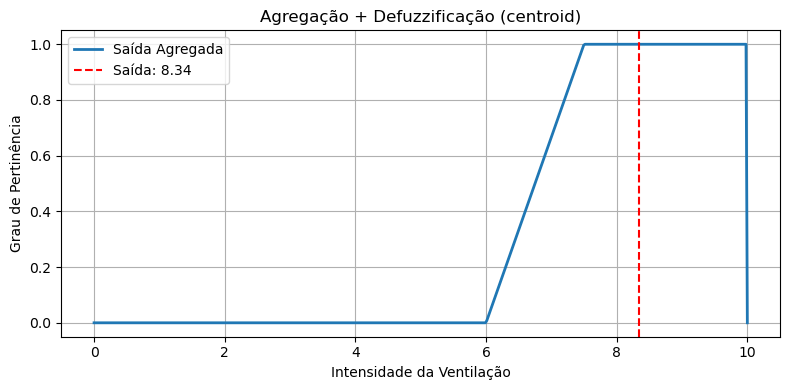

Média do Máximo

 Cenário: T=38°C, H=90%, P=9

 Operadores: AND = min, OR = max

 Regra ativada: (alta, alta, muitas) → forte com α = 1.00

Saída defuzzificada (mean_of_max): 8.75


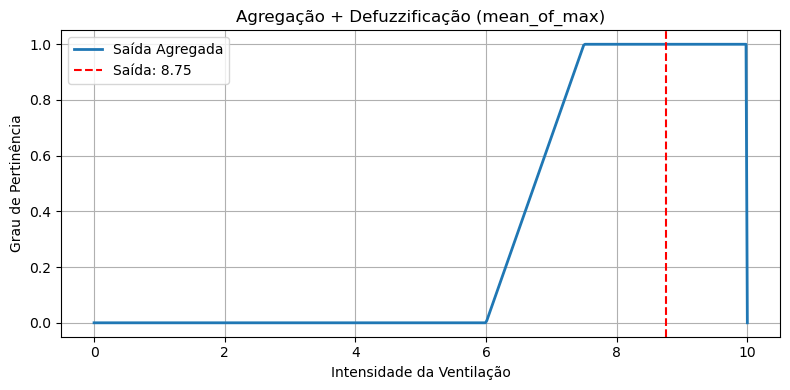

Bissetriz

 Cenário: T=38°C, H=90%, P=9

 Operadores: AND = min, OR = max

 Regra ativada: (alta, alta, muitas) → forte com α = 1.00

Saída defuzzificada (bisector): 8.38


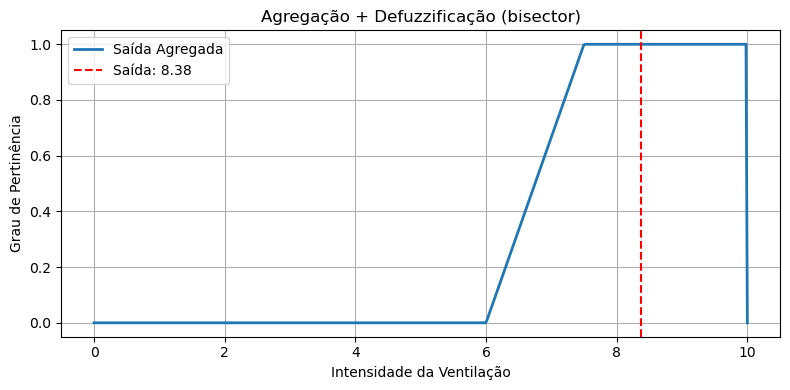

In [5]:
def execute(temp_val, hum_val, people_val, defuzz_method="centroid", and_operator="min", or_operator="max"):
    x, aggregated = inferencia_mamdani(temp_val, hum_val, people_val, and_operator, or_operator, mostrar_ativacao=False)

    if defuzz_method == "centroid":
        crisp_output = defuzzify_centroid(x, aggregated)
    elif defuzz_method == "mean_of_max":
        crisp_output = defuzzify_mean_of_max(x, aggregated)
    elif defuzz_method == "bisector":
        crisp_output = defuzzify_bisector(x, aggregated)
    else:
        raise ValueError("Método de defuzzificação inválido.")

    print(f"Saída defuzzificada ({defuzz_method}): {crisp_output:.2f}")
    
    plt.figure(figsize=(8, 4))
    plt.plot(x, aggregated, label="Saída Agregada", linewidth=2)
    plt.axvline(x=crisp_output, color="red", linestyle="--", label=f"Saída: {crisp_output:.2f}")
    plt.title(f"Agregação + Defuzzificação ({defuzz_method})")
    plt.xlabel("Intensidade da Ventilação")
    plt.ylabel("Grau de Pertinência")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def defuzzify_centroid(x, aggregated):
    if np.sum(aggregated) == 0:
        return 0
    return np.sum(x * aggregated) / np.sum(aggregated)


def defuzzify_mean_of_max(x, aggregated):
    max_value = np.max(aggregated)
    indices = np.where(aggregated == max_value)[0]
    return np.mean(x[indices])


def defuzzify_bisector(x, aggregated):
    total_area = np.sum(aggregated)
    if total_area == 0:
        print("\nNenhuma regra foi ativada. Saída definida como 0.")
        return 0

    cumulative_area = 0
    for i in range(len(x)):
        cumulative_area += aggregated[i]
        if cumulative_area >= total_area / 2:
            return x[i]


# Executar para todos os cenários definidos
for temp_val, hum_val, people_val in cenarios:
    print(f"\nCenário: T={temp_val}°C, H={hum_val}%, P={people_val}\n")
    print("Centroide")
    execute(temp_val, hum_val, people_val, defuzz_method="centroid")
    print("Média do Máximo")
    execute(temp_val, hum_val, people_val, defuzz_method="mean_of_max")
    print("Bissetriz")
    execute(temp_val, hum_val, people_val, defuzz_method="bisector")


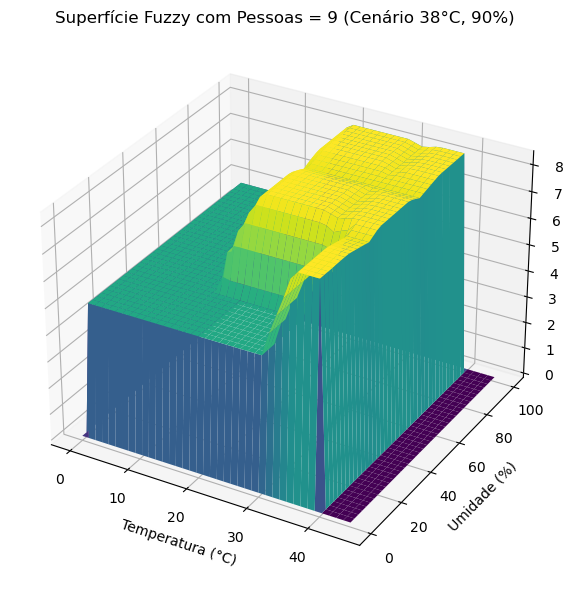

In [6]:

def plot_surface_around_scenario():
    temp_vals = np.linspace(0, 45, 40)
    hum_vals = np.linspace(0, 100, 40)
    fixed_people = 9  
    x_output = np.linspace(0, 10, 500)
    Z = np.zeros((len(temp_vals), len(hum_vals)))

    for i, t in enumerate(temp_vals):
        for j, h in enumerate(hum_vals):
            temp_fuzzy = temperature(t)
            hum_fuzzy = humidity(h)
            people_fuzzy = people_membership(fixed_people)

            output_agg = np.zeros_like(x_output)
            for rule in rules:
                temp_label, hum_label, people_label, output_label = rule
                a = temp_fuzzy[temp_label]
                b = hum_fuzzy[hum_label]
                c = people_fuzzy[people_label]

                activation = np.minimum(np.minimum(a, b), c)
                alpha = np.max(activation)

                if alpha > 0.01:
                    out_curve = output_ventilation(x_output)[output_label]
                    output_agg = np.maximum(output_agg, np.minimum(out_curve, activation))

            Z[i, j] = defuzzify_centroid(x_output, output_agg)

    T, H = np.meshgrid(temp_vals, hum_vals)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, H, Z.T, cmap="viridis")
    ax.set_xlabel("Temperatura (°C)")
    ax.set_ylabel("Umidade (%)")
    ax.set_zlabel("Ventilação")
    ax.set_title("Superfície Fuzzy com Pessoas = 9 (Cenário 38°C, 90%)")
    plt.tight_layout()
    plt.show()

plot_surface_around_scenario()
